# Short-Term Memory with the InMemorySaver Class

In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver

### Define the State

In [2]:
class State(MessagesState):
    summary: str

### Define the Nodes

In [3]:
import os
os.environ.setdefault("no_proxy", "127.0.0.1,localhost")
os.environ.setdefault("HTTPX_NO_PROXY", "127.0.0.1,localhost")
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://127.0.0.1:11434")

model_name = "gemma3" #"llama3.2:3b"

max_tokens = 100
llm = ChatOllama(model=model_name, num_predict=max_tokens, temperature=0)

In [4]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    question = "What is your question?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [5]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''

    response = llm.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [6]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"

    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it,
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = llm.invoke([HumanMessage(summary_instructions)])

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

### Define the Graph

In [7]:
graph = StateGraph(State)

In [8]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [9]:
checkpointer = InMemorySaver()
graph_compiled = graph.compile(checkpointer)

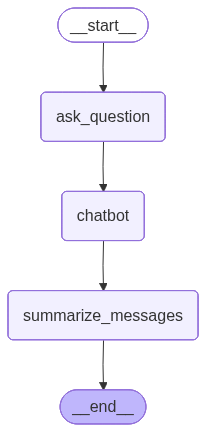

In [10]:
graph_compiled

In [11]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [13]:
graph_compiled.invoke(State(), config2)


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

Your last question was: “what was my last question?”

-------> ENTERING summarize_messages:

Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it,
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
The capital of Iran is **Tehran**.


New Conversation:
ai: What is your question?

human: what was my last question?

ai: Your last question was: “what was my last question?”





{'messages': [],
 'summary': 'The capital of Iran is **Tehran**. The conversation has shifted to a recursive inquiry about the previous question, with the AI confirming that the human’s last question was: “what was my last question?”'}

In [15]:
graph_states = [i for i in graph_compiled.get_state_history(config2)]
graph_states

[StateSnapshot(values={'messages': [], 'summary': 'The capital of Iran is **Tehran**. The conversation has shifted to a recursive inquiry about the previous question, with the AI confirming that the human’s last question was: “what was my last question?”'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c45b6-4b99-67bd-8008-2364da09baa4'}}, metadata={'source': 'loop', 'step': 8, 'parents': {}}, created_at='2025-11-18T08:48:45.943801+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c45b6-0ec3-6dc2-8007-d9022477f525'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='2943f7aa-848e-4092-bf32-0c3a75934b27'), HumanMessage(content='what was my last question?', additional_kwargs={}, response_metadata={}, id='dbe1085b-41db-4c0b-ad3a-4e2ac79bb6e9'), AIMessage(content='Your last question was: “w

In [16]:
for i in graph_states[::-1]:
    print(f'''
Messages: {i.values["messages"]}
Summary: {i.values.get("summary", "")}
Next: {i.next}
Step: {i.metadata["step"]}''')


Messages: []
Summary: 
Next: ('__start__',)
Step: -1

Messages: []
Summary: 
Next: ('ask_question',)
Step: 0

Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='08184c7e-296c-46ca-9dd7-d2fae2f5af19'), HumanMessage(content="what's the capital of Iran?", additional_kwargs={}, response_metadata={}, id='6fa79a65-9d15-4b82-958d-f6f6c354e1f4')]
Summary: 
Next: ('chatbot',)
Step: 1

Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='08184c7e-296c-46ca-9dd7-d2fae2f5af19'), HumanMessage(content="what's the capital of Iran?", additional_kwargs={}, response_metadata={}, id='6fa79a65-9d15-4b82-958d-f6f6c354e1f4'), AIMessage(content='The capital of Iran is **Tehran**.', additional_kwargs={}, response_metadata={'model': 'gemma3', 'created_at': '2025-11-18T08:48:03.9662081Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4355330800, 'load_duration': 2130759300, 'prompt_eval_count': 65, 'p